In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import numpy as np
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data sample

Load some sample radar data as a reference.

In [26]:
from ccpy.obs import n0q_to_refl
ds = xr.open_dataset("../data/boston_nov_3/n0q.subset.nc")

ds['refl'] = n0q_to_refl(ds.n0q)
ds

<xarray.Dataset>
Dimensions:  (time: 37, x: 2700, y: 2001)
Coordinates:
    band     int64 1
  * y        (y) float64 47.37 47.37 47.36 47.35 47.35 47.34 47.34 47.34 ...
  * x        (x) float64 -78.5 -78.5 -78.49 -78.48 -78.48 -78.47 -78.47 ...
  * time     (time) datetime64[ns] 2017-11-03T19:00:00 2017-11-03T19:05:00 ...
Data variables:
    n0q      (time, y, x) uint8 ...
    refl     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    history:                   Thu Feb  1 20:48:26 2018: ncrcat n0q/n0q_20171...
    NCO:                       4.6.9
    nco_openmp_thread_number:  1

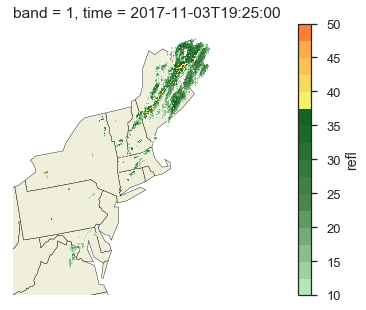

In [27]:
from ccpy.plot import usa_states_ax, make_precip_colormap
import cartopy.crs as ccrs

cmap_kws = make_precip_colormap()

ax = usa_states_ax(aspect=1.2)
ds.refl.isel(time=5).plot.pcolormesh(
    'x', 'y', ax=ax, transform=ccrs.PlateCarree(),
    infer_intervals=True, zorder=100,**cmap_kws
)
ax.autoscale()

# ds.refl.isel(time=5).plot.imshow()

## Sub-sample data

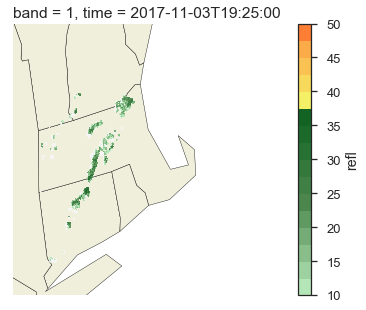

In [212]:
dsc = (
    ds
    .sel(x=slice(-73.5, -68.5), y=slice(43, 41)) #y=slice(43.8, 40.8))
    .transpose('time', 'x', 'y')
    .copy()
)

cmap_kws = make_precip_colormap()

ax = usa_states_ax(aspect=1.2)
dsc.refl.isel(time=5).plot.pcolormesh(
    'x', 'y', ax=ax, transform=ccrs.PlateCarree(),
    infer_intervals=True, zorder=100,**cmap_kws
)
ax.autoscale()

dsc.to_netcdf('temp.nc')

In [5]:
dsc = xr.open_dataset('temp.nc')

# Storm Motion

The purpose of this notebook is to explore techniques for extrapolating storm-motion vectors from real-time radar imagery. We've identified several candidate algorithms:

1. Tracking Radar Echoes with Correlation (TREC; Rinehart and Garvey, 1978)
2. Continuity of TREC vectors (COTREC; Li et al, 1995)
3. Variational Echo Tracking (VET; Germann and Zawadzki, 2002)
4. Variational Optical Flow (VarFlow; Cheung and Yeung, 2012)

These algorithms are used to generate fields of storm motion vectors using different techniques, then generally require some degree of interpolation or smoothing using either Cressman or Barnes analysis. We are fortunate to have reference implementations of (1) and (3) from TITAN, and (4) from its own source. 

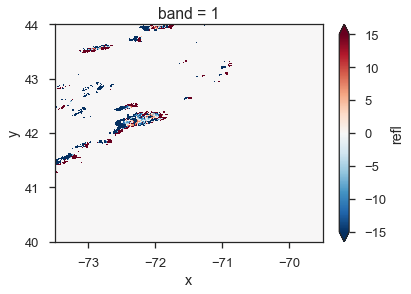

In [6]:
def add_offset(da, x):
    return da + x

def diff(da, i0, i1, dim='time'):
    return da.isel(**{dim: i1}) - da.isel(**{dim: i0})

(ds.refl
   .pipe(add_offset, 30)
   .fillna(0)
   .pipe(add_offset, -30)
   .pipe(diff, 0, 1)
   .plot.imshow(vmin=-15, vmax=15, cmap='RdBu_r')
)

## Tracking Radar Echoes with Correlation

### Algorithm Parameters

Define parameters, following recommended values and ranges in `CtrecAlg.cc`.

In [5]:
# Threshold for reflectivity filling/tracking (dBZ)
# If `floor_flg` is true, then reflectivities less than `min_echo`
# or greather than `max_echo` will be filled with random values 
# centered around this value.
# Must be <= `min_echo`
thr_dbz = -28.

# Delta dbz - perturbation for random numbers
# If `floor_flg` is true, reflectivity values less than `min_echo`
# will be filled with random numbers between 
# [thr_dbz - del_dbz, thr_dbz + del_dbz]
del_dbz = 5.

# Minimum data value to track (dBZ)
min_echo = 0.

# Maximum data value to track (dBZ)
max_echo = 75. # 1000.

# Maximum expected echo speed (km/s)
# This should be set to a reasonable value for the data. If 
# too large or small, it will have deleterious impacts on 
# both computational performance and output stability.
max_speed_echo = 25. / 1e3

# Floor data flag; if true, replace weak/missing reflectivity data
# with random numbers
floor_flg = True

# Correlation box fraction
# Maximum fraction of bad data allowed in a correlation box
cbox_fract = 0.95

# Correlation box size
# The length of one side of the correlation box, in km
cbox_size = 25

# Correlation box spacing
# The spacing between vectors in the final grid, in km
cbox_space = 10


### Utility Functions

In [6]:
def clip_uni_to_uni(x, ai, bi, af=-1., bf=1., clip=True):    
    """ Transform a uniform random variable to one with another set
    of lower/upper bounds.
    Parameters
    ----------
    x : float
        coordinate in original uniform variable space
    ai, bi : float
        lower and upper bounds of the original uniform distribution
    af, bf : float
        lower and upper bounds of the destination uniform distribution
    Returns
    -------
    float, random variable in new uniform distribution
    """
    x = x.copy()
    if clip:
        x = np.clip(x, ai, bi)
    return ((bf-af)/(bi-ai))*(x - ai) + af


def clip_and_scale_array(arr, min_x, max_x):
    arr = np.clip(arr, min_x, max_x)
    return (arr - min_x) / (max_x - min_x)

def unscale_array(arr, min_x, max_x):
    return arr * (max_x - min_x) + min_x

def grid_corr_coef(data_x, data_y):
    """ Compute the spatial correlation coefficient between two grids of data. """
    nx, ny = data_x.shape
    n_tot = nx * ny
    
    sum_base = np.nansum(data_x)
    sum_base2 = np.nansum(data_x*data_x)
    
    sum_test = np.nansum(data_y)
    sum_test2 = np.nansum(data_y*data_y)
    sum_base_test = np.nansum(data_x*data_y)

    base_variance = sum_base2 - (sum_base * sum_base / n_tot)
    test_variance = sum_test2 - (sum_test * sum_test / n_tot)
    covariance = sum_base_test - (sum_base * sum_test / n_tot)
    corr_coeff = covariance / np.sqrt(base_variance * test_variance)
    
    return corr_coeff

def nancount(x):
    return len(x[np.isnan(x)])

### Initial Setup

0.554999999999 0.554999999999
13.5135135135
14
801 801
46 46
37 741 37 741 14
23 10 18


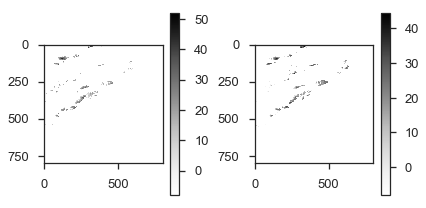

In [7]:
prev_refl = ds.refl.isel(time=4).values
curr_refl = ds.refl.isel(time=5).values

# plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axl, axr = axs
cfl = axl.imshow(prev_refl)
cfr = axr.imshow(curr_refl)
plt.colorbar(cfl, ax=axl)
plt.colorbar(cfr, ax=axr)
plt.tight_layout()

# Set up grid geometry
x = ds.x.values
y = ds.y.values
nx, ny = len(x), len(y)

KM_PER_DEG_AT_EQ = 111.
Δx = (x[1] - x[0])*KM_PER_DEG_AT_EQ
Δy = (y[-2] - y[-1])*KM_PER_DEG_AT_EQ
print(Δx, Δy)

Δt = 300.  # seconds

## Correlation grid settings - should probably dynamically 
## relate to data grid
box_nx = int(cbox_size / Δx + 1.0001)
box_ny = 1 * box_nx
box_n_tot = box_nx * box_ny
box_x_radius = box_nx // 2
box_y_radius = box_ny // 2

## Maximum amount that the echo could have moved, using
## reasonable assumptions about max winds
max_dist_echo_grid =  max_speed_echo * Δt / Δx;
print(max_dist_echo_grid)
max_search_grid = int(max_dist_echo_grid + 1 + 1e-4)
print(max_search_grid)

# Calculate the grid used for calculations. All calculations are
# done on a sparse grid at the vector spacing interval, and then
# are filled if necessary before being ouptut
# NOTE: I've modified the "end" point to account for the fact that 
#       as we get close to the edge of the grid, we lose search area
#       and at least at first want to restrict our search area to 
#       only include full grid matches.
xstart = int(max_search_grid + box_x_radius)
# xend = int(nx - max_search_grid - box_x_radius)
xend = int(nx - max_search_grid - box_nx)
ystart = int(max_search_grid + box_y_radius)
# yend = int(ny - max_search_grid - box_y_radius)
yend = int(ny - max_search_grid - box_ny)

vec_spacing = int(cbox_space / Δx)

print(nx, ny)
print(box_nx, box_ny)
print(xstart, xend, ystart, yend, max_search_grid)
print(box_x_radius, cbox_space, vec_spacing)

### Main Algorithm - Run

In [8]:
from itertools import product
from tqdm import tqdm

# Initialize output data
u_grid, v_grid = np.ones((nx, ny))*np.nan, np.ones((nx, ny))*np.nan
max_corr_grid = np.ones((nx, ny))*np.nan

HARD_BREAK = False

# Loop over all the potential base search boxes 
for (x1, y1) in tqdm(product(
    range(xstart, xend+1, vec_spacing),
    range(ystart, yend+1, vec_spacing)
), total=len(list(range(xstart, xend+1, vec_spacing)))**2):  

    # print(x1, y1)
    if HARD_BREAK: 
        break  
        
    x_begin = x1*1.
    y_begin = y1*1.
    # print(x_begin, y_begin)
        
    _base = prev_refl[x1:x1+box_nx, y1:y1+box_ny]
    _base = clip_and_scale_array(_base, min_echo, max_echo)
    # print(_base.shape)

    # Check for enough points....
    num_bad_pts = nancount(_base)
    # print(num_bad_pts)
    if (num_bad_pts / box_n_tot) > cbox_fract:
        # print("Too few", (num_bad_pts / box_n_tot))
        continue

    _corr_coeff_grid = np.empty((nx, ny))

    # print("--"*20)
    # print(max_search_grid)
    
    rs = []
    xys = []
    _tests = []
    
    # Loop over all possible boxes in the second scan that are 
    # within the search radius
    for (x2, y2) in product(
        range(x1 - max_search_grid, x1 + max_search_grid),
        range(y1 - max_search_grid, y1 + max_search_grid)
    ):
        # print(x2, y2)
        # print(x2+box_nx, y2+box_ny)
        
        x_dist = x2 - x_begin
        y_dist = y2 - y_begin
        dist = np.sqrt(x_dist*x_dist + y_dist*y_dist)
        # print(x_dist, y_dist, dist)
        
        if dist > max_dist_echo_grid:
            continue
            
        # print("CALC")
            
        # Create the subgrid of current data that is being tested
        _test = curr_refl[x2:x2+box_nx, y2:y2+box_ny]       
        _test = clip_and_scale_array(_test, min_echo, max_echo)
        # print("-->", _test.shape, nancount(_test), nancount(_base))
        
        # if (nancount(_base) < 1400) and (nancount(_test) < 1400):
        #     print("HARD STOP")
        #     HARD_BREAK = True
        #     break
        
        r = grid_corr_coef(_base, _test)
        _corr_coeff_grid[x2, y2] = r
        # print(r)
        rs.append(r)
        xys.append((x2, y2))
        _tests.append(_test)
        
    # break
    
    if not rs:
        continue
        
    # Find the point with maximum correlation
    idx = np.argmax(rs)
    x2, y2 = xys[idx]
    max_r = rs[idx]
    # print(x2, y2, max_r)
    
    # fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    # axl, axr = axs
    # cfl = axl.imshow(_base)
    # cfr = axr.imshow(_tests[idx])
    # plt.colorbar(cfl, ax=axl)
    # plt.colorbar(cfr, ax=axr)
    # plt.tight_layout()
    
    max_corr_grid[x1, y1] = max_r
    
    # Calculation motion based on the maximally-correlated point/box
    # In Rinehart (1981), it is argued that doing a second-degree curve
    # fit to the correlation field in radia/azimuthal directions 
    # centered on the point with the highest correlation coefficient
    # gives a better estimate of the true maximum and thus the location
    # to use as the final end point of the movement vector. For simplicity
    # here we will just use the midpoint of each correlation grid.
    x_begin = x1 + (box_nx / 2.)
    y_begin = y1 + (box_ny / 2.)
    x_end = x2 + (box_nx / 2.)
    y_end = y2 + (box_ny / 2.)
    
    _u = 1000.*(x_end - x_begin) / Δt
    _v = 1000.*(y_end - y_begin) / Δt
    
    # print(x1, x2, y1, y2)
    # print(x_end, x_begin, _u, y_begin, y_end, _v)    
    # print("---"*20)
    
    u_grid[x1, y1] = _u
    v_grid[x1, y1] = _v


100%|██████████| 1600/1600 [00:13<00:00, 120.57it/s]


In [9]:
u_bk = u_grid.copy()
v_bk = v_grid.copy()

### Post-processing / visualization

Visualize the output

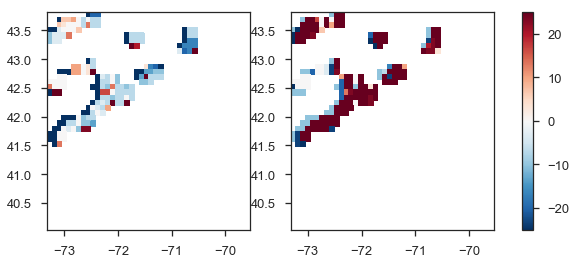

In [10]:
s = lambda x: x[xstart::vec_spacing, ystart::vec_spacing]
s1 = lambda x: x[xstart::vec_spacing]
m = lambda x: np.ma.masked_equal(x, 0)
ms = lambda x: m(s(x))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axl, axr = axs

vm = 25

cf = axl.pcolormesh(s1(x), s1(y), s(u_grid), cmap='RdBu_r', vmin=-vm, vmax=vm)
_ = axr.pcolormesh(s1(x), s1(y), s(v_grid), cmap='RdBu_r', vmin=-vm, vmax=vm)
plt.colorbar(cf, ax=axs)

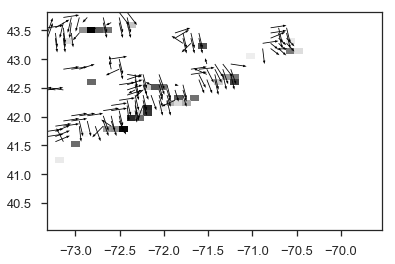

In [11]:
plt.pcolormesh(s1(x), s1(y), s(prev_refl))
plt.quiver(s1(x), s1(y), -1*ms(u_grid), -1.*ms(v_grid), 
           headlength=4, headwidth=3, angles='xy', 
           scale_units='inches', scale=200,
           color='k')
# plt.ylim(41.5, 43.5)
# plt.xlim(-73.0, -71.5)

# ax.quiver(lons.data, lats.data, 
#           uis.data, vis.data,
#           headlength=4, headwidth=3, 
#           angles='xy', scale_units='inches', scale=size*10,
#           color='k', label='{:g} mb winds'.format(uis.lv_ISBL1.data/100),
#           transform=ccrs.PlateCarree(), zorder=9999,
# )

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1711: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1711: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


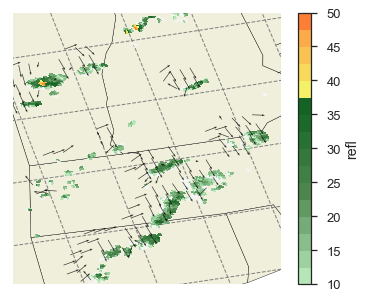

In [60]:
from ccpy.plot import usa_states_ax, make_precip_colormap
import cartopy.crs as ccrs

cmap_kws = make_precip_colormap()

ax = usa_states_ax(aspect=1.2)
ds.refl.isel(time=4).plot.pcolormesh(
    'x', 'y', ax=ax, transform=ccrs.PlateCarree(),
    zorder=10,
    **cmap_kws
)
ax.quiver(s1(x), s1(y), -1.*ms(u_grid), -1.*ms(v_grid), 
          headlength=4, headwidth=3, angles='xy', 
          scale_units='inches', scale=250, alpha=0.8,
          transform=ccrs.PlateCarree(), zorder=999,
          color='k')
gl = ax.gridlines(linewidth=1., linestyle='dashed', color='gray')


ax.autoscale()
xlo, xhi = -73, -71.5
ylo, yhi = 41.5, 44
ax.set_extent([xlo, xhi, ylo, yhi], crs=ccrs.PlateCarree())
ax.set_title("")

ax.set_aspect('auto')

Local mean filter

In [12]:
from skimage.filters import rank
from skimage.morphology import rectangle
from scipy.ndimage import generic_filter

def func_filter(input_array, func, *args, **kwargs):
    """
    Arguments:
    ----------
    input_array : ndarray
        Input array to filter.
    size : scalar or tuple, optional
        See footprint, below
    footprint : array, optional
        Either `size` or `footprint` must be defined.  `size` gives
        the shape that is taken from the input array, at every element
        position, to define the input to the filter function.
        `footprint` is a boolean array that specifies (implicitly) a
        shape, but also which of the elements within this shape will get
        passed to the filter function.  Thus ``size=(n,m)`` is equivalent
        to ``footprint=np.ones((n,m))``.  We adjust `size` to the number
        of dimensions of the input array, so that, if the input array is
        shape (10,10,10), and `size` is 2, then the actual size used is
        (2,2,2).
    output : array, optional
        The `output` parameter passes an array in which to store the
        filter output. Output array should have different name as compared
        to input array to avoid aliasing errors.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
        The `mode` parameter determines how the array borders are
        handled, where `cval` is the value when mode is equal to
        'constant'. Default is 'reflect'
    cval : scalar, optional
        Value to fill past edges of input if `mode` is 'constant'. Default
        is 0.0
    origin : scalar, optional
        The `origin` parameter controls the placement of the filter.
        Default 0.0.

    See also:
    ---------
    scipy.ndimage.generic_filter
    """
    return generic_filter(input_array, function=func, *args, **kwargs)

# Maximum radius used to find the local mean, in km
rad_mean =  25.

# Threshold used for discarding motion vectors
thr_vec = 5.

box_size = int(rad_mean / Δx)
print(box_size)

selem = rectangle(box_size, box_size)
mask = np.isnan(u_grid)

uu = u_grid.copy(order=ORDER)
vv = v_grid.copy(order=ORDER)
# uu = clip_uni_to_uni(u_grid, umin, umax, clip=False)
# u_local = rank.median(uu, selem=selem, mask=mask)
u_local = func_filter(uu, np.nanmean, size=box_size)
v_local = func_filter(vv, np.nanmean, size=box_size)
# u_local = clip_uni_to_uni(u_local, -1, 1, umin, umax)


45


/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/scipy/ndimage/filters.py:1513: RuntimeWarning: Mean of empty slice
  cval, origins, extra_arguments, extra_keywords)


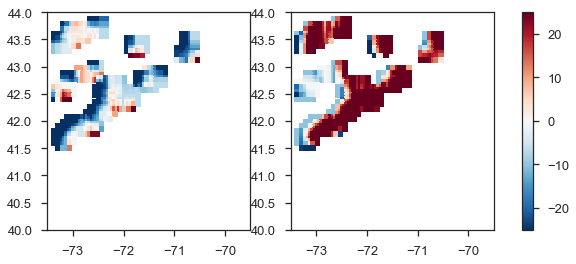

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axl, axr = axs

vm = 25

cf = axl.pcolormesh(x, y, u_local, cmap='RdBu_r', vmin=-vm, vmax=vm)
_ = axr.pcolormesh(x, y, v_local, cmap='RdBu_r', vmin=-vm, vmax=vm)
plt.colorbar(cf, ax=axs)

## Variational Echo Tracking (VET)

Following the methodology of Germann and Zawadazki (2002); instead of using a convolutional filter to find maximal correlations between subsequent radar images, VET minimizes a cost function with two constraints:

$$J_\mathrm{VET}(\mathbf{u}) = J_\Psi + J_2$$

$$J_\Psi = \iint_\Omega \beta(\mathbf{x})\left[\Psi(t_0,\mathbf{x}) - \Psi(t_0-\Delta t,\mathbf{x}-\mathbf{u}\Delta t) \right]^2\,dx\,dy$$

$$\begin{align*}
J_2 &= \gamma \iint_\Omega 
       \left(\frac{\partial^2 u}{\partial x^2}\right)^2 +
       \left(\frac{\partial^2 u}{\partial y^2}\right)^2 +
       2\left(\frac{\partial^2 u}{\partial x \partial y}\right)^2
       \,dx\,dy\\
    &+ \gamma \iint_\Omega 
       \left(\frac{\partial^2 v}{\partial x^2}\right)^2 +
       \left(\frac{\partial^2 v}{\partial y^2}\right)^2 +
       2\left(\frac{\partial^2 v}{\partial x \partial y}\right)^2
       \,dx\,dy
\end{align*}$$

where $J_\Psi$ is the sum of squares residuals f the traditional linear advection equation with zero source-sink term, and $J_2$ is a smoothness-penalty function following Wahba and Wendelberger (1980). Since this is a very large-scale, non-linear cost function, an approach as conjugate-gradient is suggested to minimize the cost function efficiently.

Because there is an implicit advection step in this algorithm, it's probably best to implement it on an Arakawa-C grid, where the $u$ winds are staggered east-west of the reflectivity cell centers, and the $v$ winds are staggered south-north. We can re-interpolate to the Arakawa-A grid by averaging over those staggered dimensions.

### Set-up

In [392]:
from skimage.measure import block_reduce

ORDER = 'C'

i0 = 20
di = 4

dsc = (
    ds
    .sel(x=slice(-75.5, -69.5), y=slice(44, 40)) #y=slice(43.8, 40.8))
    .transpose('time', 'x', 'y')
    .copy()
)

prev_refl = dsc.refl.isel(time=i0)
curr_refl = dsc.refl.isel(time=i0+di)
_prev = prev_refl.values.copy()#[..., ::-1]
_curr = curr_refl.values.copy()#[..., ::-1]
# _curr = np.roll(_prev, -10, 0)

t0 = dsc.time.isel(time=i0).values
t1 = dsc.time.isel(time=i0+di).values
# Δt = 300.*di  # seconds
_dt = (t1 - t0)
Δt = _dt / np.timedelta64(1, 's')

# Set up grid geometry
scale = 2
x = dsc.x.values[::scale]
y = dsc.y.values[::scale]
nx, ny = len(x), len(y)

KM_PER_DEG_AT_EQ = 111.
Δx = (x[1] - x[0])*KM_PER_DEG_AT_EQ*1000.
Δy = (y[-2] - y[-1])*KM_PER_DEG_AT_EQ*1000.

# Set algorithm parameters

#: Maximum number of iterations for finding the minimum
max_iterations = 100

#: Weights used for the smoothness constraint
smoothness_constraint_weights = np.array([0.001, 0.001])  # np.array([0.01, 0.01])

#: Reflectivity conservation term weighting
conservation_constraint_weight = 0.1

#: Specified first guess motion
constant_motion = [1.0, 0.0]

_conservation_matrix = np.ones((nx, ny))
_conservation_matrix *= conservation_constraint_weight
_conservation_matrix_r = _conservation_matrix.ravel()

# Decimate/scale the image with local means
_prev = block_reduce(_prev, 
                     block_size=(scale, scale), func=np.nanmean)
_curr = block_reduce(_curr, 
                     block_size=(scale, scale), func=np.nanmean)

# Post-process the images so we don't have any NaNs to worry about
min_val, max_val = 0, 100.
_prev = np.clip(_prev, min_val, max_val)
_curr = np.clip(_curr, min_val, max_val)
_prev[np.isnan(_prev)] = min_val
_curr[np.isnan(_curr)] = min_val

_prev_r = _prev.T.ravel()
_curr_r = _curr.T.ravel()

# Initialize "first guess" U / V
# _u = np.ones((nx+1, ny)) * constant_motion[0]
# _v = np.ones((nx, ny+1)) * constant_motion[1]
_u = np.zeros((nx+1, ny), dtype=np.float64) + constant_motion[0] # + 0.1*np.random.randn(nx+1, ny)
_v = np.zeros((nx, ny+1), dtype=np.float64) + constant_motion[1] # + 0.1*np.random.randn(nx, ny+1)

nxu, nyu = _u.shape
ntu = nxu*nyu
nxv, nyv = _v.shape
ntv = nxv*nyv

_u_r = _u.ravel()
_v_r = _v.ravel()

print(_prev.shape, nx, ny, Δx, Δy, Δt)
print(nxu, nyu, ntu)
print(nxv, nyv, ntv)
print(t0, t1)

(601, 401) 601 401 1110.0 1110.0 1200.0
602 401 241402
601 402 241602
2017-11-03T20:40:00.000000000 2017-11-03T21:00:00.000000000


/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


48.25 0.0
51.5 0.0


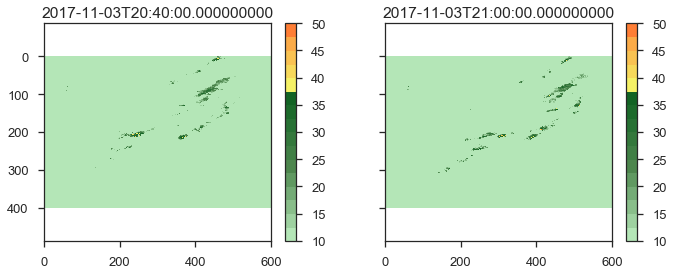

In [393]:
from ccpy.plot import get_figsize
from ccpy.plot import make_precip_colormap

figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

cmap_kws = make_precip_colormap(clip=True)
del cmap_kws['extend']

ucf = axu.imshow(_prev.T, **cmap_kws)
vcf = axv.imshow(_curr.T, **cmap_kws)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)
axu.set_title(t0)
axv.set_title(t1)

print(_prev.max(), _prev.min())
print(_curr.max(), _curr.min())

### Cost Function / Gradient Implementations

Working our way outwards, we begin with the cost function and gradient calculations corresponding to `_calcCostFunction` and `_calcGradients`.

In [394]:
from numba import jit

@jit(nopython=True)
def calc_cost_function(prev_r, curr_r, u_r, v_r, conservation_matrix_r):
    
    # Raveled views into the arrays
    # prev_r, curr_r, u_r, v_r = prev.ravel(), curr.ravel(), u.ravel(), v.ravel()
    # conservation_matrix_r = conservation_matrix.ravel()
    
    # Compute the cost function of reflectivity conservation
    ffz = 0.
    # nx, ny = curr.shape
    for y in range(1, ny-1):
        for x in range(1, nx-1):    
            idx = y*nx + x
            idxn = (y+1)*nx + x
            idxs = (y-1)*nx + x
            idxe = y*nx + (x+1)
            idxw = y*nx + (x-1)
            
            uidx = y*nxu + x
            uidxw = y*nxu + (x-1)
            
            vidx = y*nxv + x
            vidxs = (y-1)*nxv + x
            
            ffz_increment = conservation_matrix_r[idx] * (
                (curr_r[idx] - prev_r[idx]) / Δt +
                0.25 / Δx * (u_r[uidx] + u_r[uidxw])*(prev_r[idxe] - prev_r[idxw]) +
                0.25 / Δy * (v_r[vidx] + v_r[vidxs])*(prev_r[idxn] - prev_r[idxs])
            )
            
            if not np.isnan(ffz_increment):
                ffz += ffz_increment
    # print(ffz)
                
    # Compute the V-relative smoothness constraint
    ffsmsv = 0.
    # nx, ny = v.shape
    sm_v = smoothness_constraint_weights[1]
    for y in range(1, nyv-1):
        for x in range(1, nxv-1):
            idx = y*nxv + x
            idxn = (y+1)*nxv + x
            idxs = (y-1)*nxv + x
            idxe = y*nxv + (x+1)
            idxw = y*nxv + (x-1)
            
            vfactor1 = (v_r[idxn] - 2.0*v_r[idx] + v_r[idxs]) # / (2*Δy)
            vfactor2 = (v_r[idxe] - 2.0*v_r[idx] + v_r[idxw]) # / (2*Δx)
            
            ffsmsv += sm_v*((vfactor1*vfactor1) + (vfactor2*vfactor2))
    # print(ffsmsv)
            
    # Compute the U-relative smoothness constraint
    ffsmsu = 0.
    # nx, ny = u.shape
    sm_u = smoothness_constraint_weights[0]
    for y in range(1, nyu-1):
        for x in range(1, nxu-1):
            idx = y*nxu + x
            idxn = (y+1)*nxu + x
            idxs = (y-1)*nxu + x
            idxe = y*nxu + (x+1)
            idxw = y*nxu + (x-1)
            
            ufactor1 = (u_r[idxn] - 2.0*u_r[idx] + u_r[idxs]) # / (2*Δy)
            ufactor2 = (u_r[idxe] - 2.0*u_r[idx] + u_r[idxw]) # / (2*Δx)
            
            ffsmsu += sm_u*((ufactor1*ufactor1) + (ufactor2*ufactor2))
    # print(ffsmsu)
            
    ffsms = ffsmsu + ffsmsv
    # print(ffsms)
    cost_function = ffz + ffsms
    # print(cost_function)
    
    return cost_function


@jit(nopython=True)
def calc_gradients(prev_r, u_r, v_r, conservation_matrix_r):
    
    u_grad_r, v_grad_r = np.ones_like(u_r, dtype=np.float64)*-9999*0, \
                         np.ones_like(v_r, dtype=np.float64)*-9999*0
    
    # Raveled views into the arrays
    # prev_r, u_r, v_r = prev.ravel(), u.ravel(), v.ravel()
    # conservation_matrix_r = conservation_matrix.ravel()
    # u_grad_r, v_grad_r = u_grad.ravel(), v_grad.ravel()
    
    # Calculate the gradient of the reflectivity conservation equation
    # nx, ny = prev.shape
    count = 0
    for x in range(1, nx-2):
        for y in range(1, ny-1):
            idx = y*nx + x
            idxe = y*nx + (x+1)
            idxee = y*nx + (x+2)
            idxw = y*nx + (x-1)
            uidx = y*nxu + x
            
            u_grad_r[uidx] = count
            count += 1
            u_grad_r[uidx] = (0.5 / Δx) * \
                             (conservation_matrix_r[idx] * (prev_r[idxe] - prev_r[idxw]) +
                              conservation_matrix_r[idxe] * (prev_r[idxee] - prev_r[idx]))

    count = 0
    for x in range(1, nx-1):
        for y in range(1, ny-2):
            idx = y*nx + x
            idxn = (y+1)*nx + x
            idxnn = (y+2)*nx + x
            idxs = (y-1)*nx + x
            vidx = y*nxv + x
            
            v_grad_r[vidx] = count
            count += 1
            v_grad_r[vidx] = (0.5 / Δy) * \
                             (conservation_matrix_r[idx] * (prev_r[idxn] - prev_r[idxs]) +
                              conservation_matrix_r[idxn] * (prev_r[idxnn] - prev_r[idx]))
    
    
    # Calculate the gradients of the smoothness constraint
    sm_u = smoothness_constraint_weights[0]
    # nxu, nyu = u_grad.shape 
    for y in range(2, nyu-2):
        for x in range(2, nxu-2):
            idx = y*nxu + x
            idxe = y*nxu + (x+1)
            idxee = y*nxu + (x+2)
            idxw = y*nxu + (x-1)
            idxww = y*nxu + (x-2)
            idxn = (y+1)*nxu + x
            idxnn = (y+2)*nxu + x
            idxs = (y-1)*nxu + x
            idxss = (y-2)*nxu + x
            
            if y > 1:
                uym2 = u_r[idxss]
            else:
                uym2 = 2.0 * u_r[idxs] - u_r[idx]
            
            if y < (nyu - 1):
                uyp2 = u_r[idxnn]
            else:
                uyp2 = 2.0 * u_r[idxn] - u_r[idx]
                
            if x > 1:
                uxm2 = u_r[idxww]
            else:
                uxm2 = 2.0 * u_r[idxw] - u_r[idx]
            
            if  x < nxu:
                uxp2 = u_r[idxee]
            else:
                uxp2 = 2.0 * u_r[idxe] - u_r[idx]
                
            u_grad_r[idx] = u_grad_r[idx] + sm_u*(
                2.0*(
                    -2.0*(u_r[idxn] + u_r[idxs] - 2.0*u_r[idx]) +
                    (u_r[idx] + uym2 - 2.0 * u_r[idxs]) +
                    (uyp2 + u_r[idx] - 2.0 * u_r[idxn])
                ) +
                2.0*(
                    -2.0*(u_r[idxe] + u_r[idxw] - 2.0*u_r[idx]) +
                    (u_r[idx] + uxm2 - 2.0 * u_r[idxw]) +
                    (uxp2 + u_r[idx] - 2.0 * u_r[idxe])
                )
            )
            
    sm_v = smoothness_constraint_weights[1]
    # nx, ny = v_grad.shape
    for y in range(2, nyv-2):
        for x in range(2, nxv-2):
            idx = y*nxv + x
            idxe = y*nxv + (x+1)
            idxee = y*nxv + (x+2)
            idxw = y*nxv + (x-1)
            idxww = y*nxv + (x-2)
            idxn = (y+1)*nxv + x
            idxnn = (y+2)*nxv + x
            idxs = (y-1)*nxv + x
            idxss = (y-2)*nxv + x
                        
            if y > 1:
                vym2 = v_r[idxss]
            else:
                vym2 = 2.0 * v_r[idxs] - v_r[idx]
                
            if y < (nyv - 1):
                vyp2 = v_r[idxnn]
            else:
                vyp2 = 2.0 * v_r[idxn] - v_r[idx]
                
            if x > 1:
                vxm2 = v_r[idxww]
            else:
                vxm2 = 2.0 * v_r[idxw] - v_r[idx]
            
            if x < nxv:
                vxp2 = v_r[idxee]
            else:
                vxp2 = 2.0 * v_r[idxe] - v_r[idx]
                
            v_grad_r[idx] = v_grad_r[idx] + sm_v*(
                2.0*(
                    -2.0*(v_r[idxn] + v_r[idxs] - 2.0*v_r[idx]) +
                    (v_r[idx] + vym2 - 2.0 * v_r[idxs]) +
                    (vyp2 + v_r[idx] - 2.0 * v_r[idxn])
                ) + 
                2.0*(
                    -2.0*(v_r[idxe] + v_r[idxw] - 2.0*v_r[idx]) +
                    (v_r[idx] + vxm2 - 2.0 * v_r[idxw]) +
                    (vxp2 + v_r[idx] - 2.0 * v_r[idxe])
                ) 
            )
            
    return u_grad_r, v_grad_r
    

In [395]:
print("cost", end=" ")
cost = calc_cost_function(_prev_r, _curr_r, _u_r, _v_r, _conservation_matrix_r)
print("done")
print("gradients", end=" ")
_u_grad_r, _v_grad_r = calc_gradients(_prev_r, _u_r, _v_r, _conservation_matrix_r)
print("done")

_u_grad = _u_grad_r.reshape((nxu, nyu), order='F')
_v_grad = _v_grad_r.reshape((nxv, nyv), order='F')

_gnu = [np.sum(_u_grad**2), ]
_gnv = [np.sum(_v_grad**2), ]

print(cost, _gnu, _gnv)

cost done
gradients done
0.9663595157657668 [0.003704379495634123] [0.006098633811178469]


0.00364864864865 -0.00337837837838
0.00342342342342 -0.00369369369369


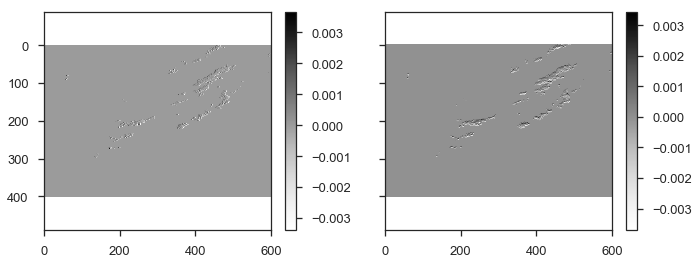

In [396]:
from ccpy.plot import get_figsize
figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

vm = 200
cmap_kws = dict(vmin=-vm, vmax=vm, cmap='RdBu_r')

ucf = axu.imshow(_u_grad.T)#, vmin=0)#, **cmap_kws)
vcf = axv.imshow(_v_grad.T)#, vmin=0)#, **cmap_kws)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(_u_grad.max(), _u_grad.min())
print(_v_grad.max(), _v_grad.min())

Both of the previous functions are used within `_calcCostFuncGradient`, which is what is coupled to the conjugate gradient descent to perform the global minimization necessary to compute wind vectors. However, I'm not sure this function needs to be distinct from `_generateMotionVectors`; in Python it's only a handful of lines of code.

In [397]:
# @jit(nopython=True)
def calc_cost_func_gradient(prev_r, curr_r, u_r, v_r, conservation_matrix_r):
    
    # Calculate the cost function
    cost = calc_cost_function(prev_r, curr_r, u_r, v_r, conservation_matrix_r)
    
    # Calculate the gradients
    u_grad_r, v_grad_r = calc_gradients(prev_r, u_r, v_r, conservation_matrix_r)
    
    gnu = np.nansum(u_grad_r**2)
    gnv = np.nansum(v_grad_r**2)
    gnm = np.sqrt(gnu + gnv)
    
    return cost, gnm
    
cost, gnm = calc_cost_func_gradient(_prev_r, _curr_r, _u_r, _v_r, _conservation_matrix_r)
print(cost, gnm)

0.9663595157657668 0.0990101676941


### UNUSED

The wind and gradient fields are optimized through a conjugate gradient descent, so we implement the minimization routine `_performMinimization` next.

In [398]:
def uv_to_vec(u, v, u_grad, v_grad):
    _u, _v = u.copy(), v.copy()
    _u_grad, _v_grad = u_grad.copy(), v_grad.copy()
    
    nxu, nyu = _u.shape
    nxv, nyv = _v.shape
    ntu = nxu*nyu
    ntv = nxv*nyv
    nt = ntu + ntv

    _u_r, _v_r = _u.ravel(), _v.ravel()
    _u_grad_r, _v_grad_r = _u_grad.ravel(), _v_grad.ravel()
    _xx = np.zeros([nt, ])
    _gg = np.zeros([nt, ])

    for x in range(1, nxu-1):
        for y in range(1, nyu-1):
            xx_idx = (y-1) + (x-1)*(nyu-2)
            u_idx = y*nxu + x
            _xx[xx_idx] = _u_r[u_idx]
            _gg[xx_idx] = _u_grad_r[u_idx]
            
    u_xx_grid_size = (nxu - 2) * (nyu - 2)
    for x in range(1, nxv-1):
        for y in range(1, nyv-1):
            xx_idx = (y-1) + (x-1)*(nyv - 2) + u_xx_grid_size
            v_idx = y*nxv + x
            _xx[xx_idx] = _v_r[v_idx]
            _gg[xx_idx] = _v_grad_r[v_idx]
            
    return _xx, _gg
            
_xx, _gg = uv_to_vec(_u, _v, _u_grad, _v_grad)
print(_xx.shape, _gg.shape)

(483004,) (483004,)


Now we run into a pretty serious problem. We've essentially built a situation to try to solve (9) from Germann and Zawadzki (2002) by generating two components:

1. An initial guess of the $u$ and $v$ wind components
2. The gradients of $J_\mathrm{VET}(\mathbf{u})$ with respect to $u$ and $v$

We now need to retrieve all the elements of $u$ and $v$ on our domain simultaneously, in one global minimization step. This is a very large-scale, nonlinear optimization problem. The reference paper recommends using the conjugate-gradient algorithm to determine the search direction and step length to use in iteratively solving the problem. The reference TITAN code leverages an old Fortran implementation of the L-BFGS algorithm called `VA15AD`; I found two implementations of the algorithm [here](https://github.com/takemasa-miyoshi/letkf/blob/a271c099124c20f7c7fa118558f48c8aef122590/common/minimizelib.f90) and in TITAN.

This implementation is specially-designed to work with the problem formulation we have here. It derives from a 1988 paper by Liu and Nocedal, "On the limited memory BFGS method for large scale optimization". Several reference papers adopt similar approaches and the algorithm to solve them:

1. Sun, 1993. "Fitting a Catersian Prediction Model to Radial Velocity Data from Single Doppler Radar." Journal of Atmospheric and Oceanic Technology
2. [Liou and Luo, 2001. "An Investigation of the Moving-Frame Single-Doppler Wind Retrieval Technique using Tawian area Mesoscale Experiment Low-Level Data"](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0450%282001%29040%3C1900%3AAIOTMF%3E2.0.CO%3B2)
3. [Liou, 1999. "Single Radar Recovery of a Cross-beam Wind Components Using a Modified Moving Frame of Reference Technique"](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0426%281999%29016%3C1003%3ASRROCB%3E2.0.CO%3B2)

In [254]:
from scipy.sparse.linalg import cg, spsolve, spsolve_triangular
from scipy.sparse import spdiags

# _xx_sparse = spdiags(_xx, 0, len(_xx), len(_xx))
_gg_sparse = spdiags(_gg, 0, len(_gg), len(_gg))

sol, info = cg(_gg_sparse, _xx, x0=_xx, tol=1e-6, maxiter=200)
# sol = spsolve(_gg_sparse, _xx)
print(info)

200


In [255]:
def vec_to_uv(vec, u, v):
    _new_u, _new_v = np.zeros_like(u), np.zeros_like(v)
    _new_u_r, _new_v_r = _new_u.ravel(), _new_v.ravel()

    nxu, nyu = u.shape
    nxv, nyv = v.shape
    ntu = nxu*nyu
    ntv = nxv*nyv
    nt = ntu + ntv
    
    for x in range(1, nxu-1):
        for y in range(1, nyu-1):
            xx_idx = (y-1) + (x-1)*(nyu - 2)
            u_idx = y*nxu + x

            _new_u_r[u_idx] = vec[xx_idx]
            
    u_xx_grid_size = (nxu - 2) * (nyu - 2)
    for x in range(1, nxv-1):
        for y in range(1, nyv-1):
            xx_idx = (y-1) + (x-1)*(nyv - 2) + u_xx_grid_size
            v_idx = y*nxv + x

            _new_v_r[v_idx] = vec[xx_idx]
            
    return _new_u, _new_v

_new_u, _new_v = vec_to_uv(sol, _u, _v)

15124550.2342 -11250113.7841
6422464.07351 -9889584.82432


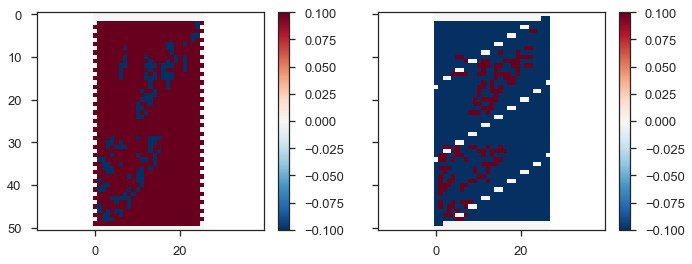

In [256]:
figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

vm = 0.1
cmap_kws = dict(vmin=-vm, vmax=vm, cmap='RdBu_r')

ucf = axu.imshow(_new_u, **cmap_kws)
vcf = axv.imshow(_new_v, **cmap_kws)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(_new_u.max(), _new_u.min())
print(_new_v.max(), _new_v.min())

---

###  Optimization via SciPy

So the optimization we have to do here actually isn't as bad as I thought at first glance. We have a cost function $J(\mathbf{u})$, which returns a scalar, and we know the gradient of $J$ with respect to each element in $\mathbf{u}$. So we can actually re-cast this as a traditional optimization problem, using SciPy's solvers:

2/1/2018 - I changed the order to 'F' for the copies to try to solve a weird issue with striding

In [356]:
from scipy.optimize import minimize

# def calc_cost_function(prev, curr, u, v, conservation_matrix):
def _min_calc_cost_function(uv):
    u, v = uv[:ntu].copy(order=ORDER), uv[ntu:].copy(order=ORDER)
    cost = calc_cost_function(_prev_r, _curr_r, u, v, _conservation_matrix_r)
    return cost

# def calc_gradients(prev, u, v, conservation_matrix):
def _min_calc_gradients(uv):
    u, v = uv[:ntu].copy(order=ORDER), uv[ntu:].copy(order=ORDER)
    _u_grad_r, _v_grad_r = calc_gradients(_prev_r, u, v, _conservation_matrix_r)
    grads = np.concatenate([_u_grad_r, _v_grad_r])
    return grads

_u_start, _v_start = _u_r.copy(order=ORDER), _v_r.copy(order=ORDER)
_uv_start = np.concatenate([_u_start, _v_start])

opts_bfgs = {
    'disp': True,
}
opts_lbfgsb = {
    'disp': True, 
    'maxiter': 100, 'maxls': 40, 'maxcor': 25, 'eps': 1e-8,
    'ftol': 1e-6, 'gtol': 1e-6
}
opts_tnc = {
    'disp': True, 'eta': 0.1, 'maxiter': 1000,
}
opts_cg = {
    'disp': True, 'maxiter': 20, 'norm': 1e-6,
}
opts_generic = {
    'disp': True, 'maxiter': 100, 'xtol': 1e-6
}


res = minimize(_min_calc_cost_function, _uv_start, jac=_min_calc_gradients, 
#                method='BFGS', options=opts_bfgs,
#                method='CG', options=opts_cg,
               method='TNC', options=opts_tnc
#                method='L-BFGS-B', options=opts_lbfgsb
)

print(res)
res.x.min(), res.x.max()

     fun: 0.012986589372713433
     jac: array([-0., -0., -0., ..., -0., -0., -0.])
 message: 'Linear search failed'
    nfev: 150
     nit: 1
  status: 4
 success: False
       x: array([ 1.,  1.,  1., ...,  0.,  0.,  0.])


(-0.0065964087444165456, 1.0794060115489368)

Visualize iterated $u$ and $v$ fields

1.07940601155 0.934886564167
0.0201339564492 -0.00659640874442


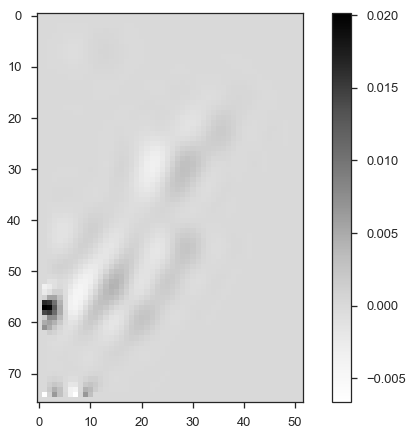

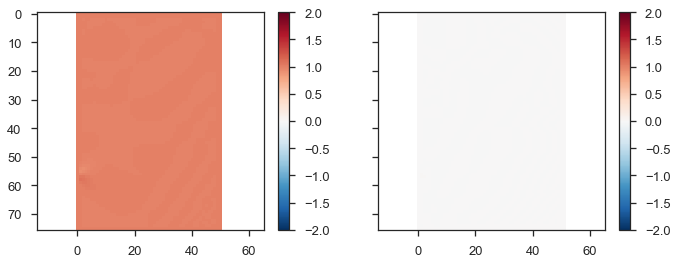

In [357]:
new_u, new_v = res.x[:ntu], res.x[ntu:]
new_u = new_u.reshape((nxu, nyu), order='F')
new_v = new_v.reshape((nxv, nyv), order='F')

cf = plt.imshow(new_v)
plt.colorbar(cf)

figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

vm = 2
cmap_kws = dict(vmin=-vm, vmax=vm, cmap='RdBu_r')

ucf = axu.imshow(new_u, **cmap_kws)
vcf = axv.imshow(new_v, **cmap_kws)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(new_u.max(), new_u.min())
print(new_v.max(), new_v.min())

### Gradient checks

Some quality checks to see whether or not the gradient is being computed correctly

0.0445371378666 0.0441144722115


Text(0.5,1,'exact_v')

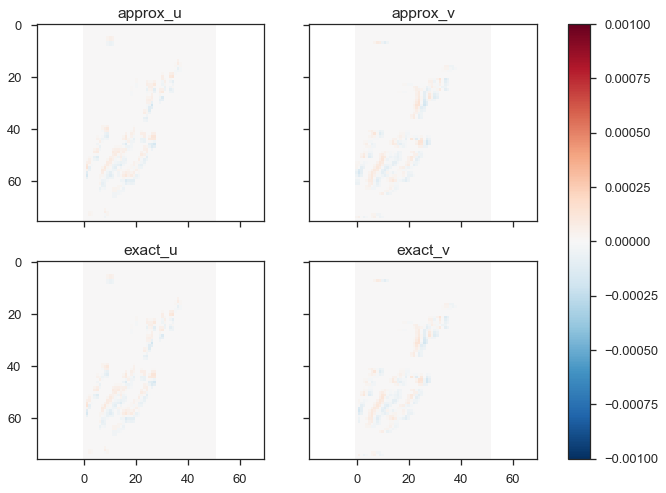

In [358]:
from scipy.optimize import check_grad
# check_grad(_min_calc_cost_function, _min_calc_gradients, _uv_start)

from scipy.optimize import approx_fprime

approx = approx_fprime(_uv_start, _min_calc_cost_function, 1e-9)
exact = _min_calc_gradients(_uv_start)

print(np.abs(approx).sum(), np.abs(exact).sum())

approx_u, approx_v = approx[:ntu], approx[ntu:]
approx_u, approx_v = approx_u.reshape((nxu, nyu), order='F'), \
                      approx_v.reshape((nxv, nyv), order='F')
exact_u, exact_v = exact[:ntu], exact[ntu:]
exact_u, exact_v = exact_u.reshape((nxu, nyu), order='F'), \
                   exact_v.reshape((nxv, nyv), order='F')

figsize = get_figsize(2, 2, size=4, aspect=1.4)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,
                        figsize=figsize)
axs = axs.ravel()

vm = 0.001
cmap_kws = dict(vmin=-vm, vmax=vm, cmap='RdBu_r')

cf = axs[0].imshow(approx_u, **cmap_kws)
axs[1].imshow(approx_v, **cmap_kws)
axs[2].imshow(exact_u, **cmap_kws)
axs[3].imshow(exact_v, **cmap_kws)
plt.colorbar(cf, ax=axs)

axs[0].set_title("approx_u")
axs[1].set_title("approx_v")
axs[2].set_title("exact_u")
axs[3].set_title("exact_v")

---

### Main Algorithm

Putting it all together... we iteratively refine our guesses for $u$, $v$, update our cost functions, and work it out.

In [360]:
_u_start, _v_start = _u_r.copy(), _v_r.copy()
_uv_start = np.concatenate([_u_start, _v_start])

us, vs = [_u.copy(), ], [_v.copy(), ]
_uv_iter = _uv_start.copy()
for i in range(35):
    print("Iteration:", i, end=" ")

    res = minimize(_min_calc_cost_function, _uv_iter, jac=_min_calc_gradients, 
                   method='L-BFGS-B', options=opts_lbfgsb,
#                    method='CG', options=opts_cg,
#                    method='TNC', options=opts_tnc
    )
    
    new_u, new_v = res.x[:ntu], res.x[ntu:]
    us.append(new_u.reshape((nxu, nyu), order='F').copy())
    vs.append(new_v.reshape((nxv, nyv), order='F').copy())
    _uv_iter = res.x.copy()
    
    l2_norm = np.sqrt(
        np.sum((vs[-1] - vs[-2])**2) +
        np.sum((us[-1] - us[-2])**2)
    )    
    
    print(res.x.min(), res.x.max(), l2_norm, res.status)
    print(res.message)
    
    if (l2_norm < 1e-6): 
        print("CONVERGED", l2_norm)
        break

Iteration: 0 -0.085217767973 1.13383824473 1.03841477551 0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Iteration: 1 -0.0802597988788 1.16057344407 0.267735042079 0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Iteration: 2 -0.0803224232314 1.16322113252 0.0192277761544 0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Iteration: 3 -0.0803224232314 1.16322113252 8.44157332807e-13 0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
CONVERGED 8.44157332807e-13


-0.127330712666 0.155647642319
-0.153173232772 0.152841351471


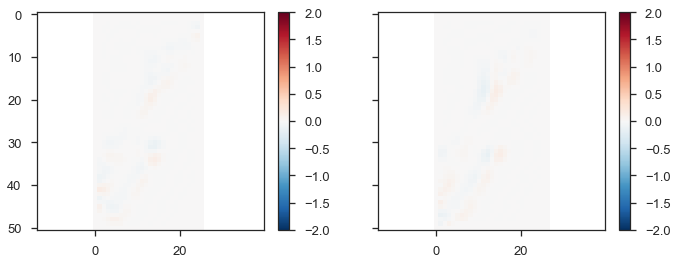

In [288]:
figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

vm = 2
cmap_kws = dict(vmin=-vm, vmax=vm, cmap='RdBu_r')

ucf = axu.imshow(us[-1], **cmap_kws)
vcf = axv.imshow(vs[-1], **cmap_kws)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(new_u.min(), new_u.max())
print(new_v.min(), new_v.max())

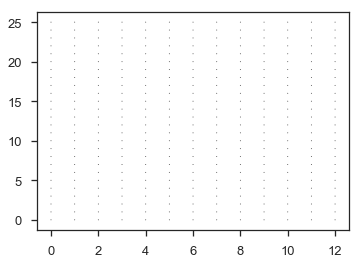

In [289]:
figsize = get_figsize(1, 1, size=4, aspect=1.4)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                       figsize=figsize)

_ut = us[-1].copy(order=ORDER)
_ut = 0.5*(_ut[:-1] + _ut[1:])
_vt = vs[-1].copy(order=ORDER)
_vt = 0.5*(_vt[..., :-1] + _vt[..., 1:])

rs = 2
ax.quiver(np.flipud(_ut[::rs, ::rs]), np.flipud(_vt[::rs, ::rs]),
          headlength=4, headwidth=3, angles='xy', 
          scale_units='xy', scale=10, alpha=0.8,
          color='k')

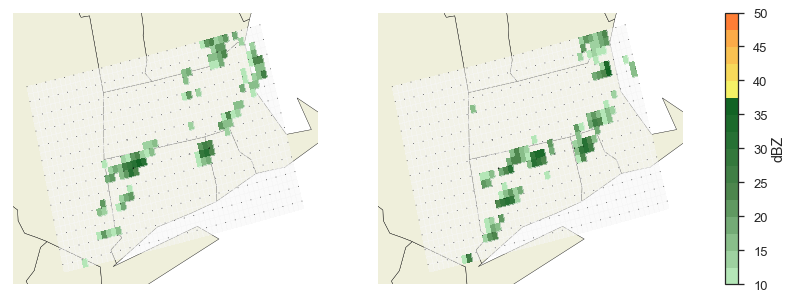

In [290]:
from ccpy.plot import get_figsize, usa_states_ax, make_precip_colormap, STATE_PROJ
import cartopy.crs as ccrs

cmap_kws = make_precip_colormap(clip=False)
del cmap_kws['extend']

# Re-center staggered dimensions by taking averages between edges
_ut = us[-1].copy()
_ut = 0.5*(_ut[:-1] + _ut[1:])
_vt = vs[-1].copy()
_vt = 0.5*(_vt[..., :-1] + _vt[..., 1:])

figsize = get_figsize(1, 2, size=5, aspect=1.5)
fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True,
                        subplot_kw=dict(
                            projection=STATE_PROJ, aspect='auto'
                        ))
axl, axr = axs[:]

for ax in axs:
    ax = usa_states_ax(ax=ax)
    
pc = axl.pcolormesh(x, y, _prev.T,
                    transform=ccrs.PlateCarree(), zorder=100, 
                    rasterized=True, linewidth=0, edgecolor='face', **cmap_kws)
pc = axr.pcolormesh(x, y, _curr.T,
                    transform=ccrs.PlateCarree(), zorder=100, 
                    rasterized=True, linewidth=0, edgecolor='face', **cmap_kws)
for ax in axs:
    ax.quiver(x[::-rs], y[::rs],
              _ut[::-rs, ::rs].T, _vt[::-rs, ::rs].T,
              headlength=4, headwidth=3, angles='xy', 
              scale_units='inches', scale=5, alpha=0.8,
              color='k', zorder=200, transform=ccrs.PlateCarree())
    ax.autoscale()

plt.colorbar(pc, ax=axs, label='dBZ')

## VarFlow / ROVER

Following Bruhn et al (2003), we seek to implement a refined optical flow computation called the *combined local-global* (CLG) method, which combines the advantages of the global Horn-Schunck approach with the local Lucas-Kanade one. The algorithm computes the optic flow field $$(u(x,y),v(x,y))^T$$ at some time $t$ subect to the minimization of the energy functional 

$$E(u,v) = \int_\Omega \left( w^T J_p(\nabla_3 f)w + \alpha(|\nabla u|^2 + |\nabla v|^2) \right) dx dy$$

where the vector field $w(x,y) = (u(x,y),v(x,y),1)^T$ essentially describes the displacement, $\nabla$ is the spatial gradient operator, and $\nabla_3 f$ is the spatiotemporal gradient of $f$, or $(f_x, f_y, f_t)^T$. Matrix $J_p(\nabla_3 f)$ is a structure tensor given by

$$K_\rho \circ (J_p(\nabla_3 f J_p(\nabla_3 f^T)))$$

where $\circ$ is the convolution operator and $K_\rho$ is a Gaussian with standard deviation $\rho$. The weighting parameter $\alpha > 0$ is a regularization parameter. 

Minimizing $E(u, v)$ recovers the optical flow field. This can be accomplished by solving two simultaneous, coupled Euler-Lagrange equations

$$\Delta u - \frac{1}{\alpha}\left(K_\rho\circ(f^2_x)u + K_\rho\circ(f_xf_y)v + K_\rho\circ(f_xf_t) \right) = 0$$
$$\Delta v - \frac{1}{\alpha}\left(K_\rho\circ(f_xf_y)u + K_\rho\circ(f^2_y)v + K_\rho\circ(f_yf_t) \right) = 0$$

where $\Delta$ here indicates the Laplacian operator.

In [451]:
from skimage.measure import block_reduce

i0 = 20
di = 2

dsc = (
    ds
    .sel(x=slice(-73.5, -69.5), y=slice(43.8, 40.8))
    .copy()
)

prev_refl = dsc.refl.isel(time=i0)
curr_refl = dsc.refl.isel(time=i0+di)
_prev = prev_refl.values.copy()
_curr = curr_refl.values.copy()
Δt = 300.*di  # seconds
print("Δt", Δt)

# Set up grid geometry
scale = 2
x = dsc.x.values[::scale]
y = dsc.y.values[::scale]
nx, ny = len(x), len(y)

KM_PER_DEG_AT_EQ = 111.
Δx = (x[1] - x[0])*KM_PER_DEG_AT_EQ*1000.
Δy = (y[-2] - y[-1])*KM_PER_DEG_AT_EQ*1000.
print("Δx", Δx)
print("Δy", Δy)

# Set Algorithm Parameters

# Optical Flow Parameters

#: Gaussian convolution for image smoothing
σ = 9

#: Gaussian convolution for local vector field smoothing
ρ = 1.5

#: Regularization parameters in the energy function
α = 4000. # 2000.

#: Finest spatial scale (pixels)
Lf = 1

#: Coarsest spatial scale (pixels)
Lc = 7

# Spatial derivative masks
mask_x = np.array([1., -8., 0., 8., -1.])/12.
mask_y = np.array([-1., 8., 0., -8., 1.])/12.

# Decimate/scale the image with local means
_prev = block_reduce(_prev, 
                     block_size=(scale, scale), func=np.nanmean)
_curr = block_reduce(_curr, 
                     block_size=(scale, scale), func=np.nanmean)

# Post-process the images so we don't have any NaNs to worry about
min_val, max_val = -20, 100.
_prev = np.clip(_prev, min_val, max_val)
_curr = np.clip(_curr, min_val, max_val)
_prev[np.isnan(_prev)] = min_val
_curr[np.isnan(_curr)] = min_val

# Radar Transformation
Zc = 33.0  # dBZ
ζ = 4.0  # dBZ

def refl_to_G(Z, Zc=Zc, ζ=ζ):
    return np.arctan((Z - Zc) / ζ)

def G_to_refl(G, Zc=Zc, ζ=ζ):
    return ζ*np.tan(G) + Zc

_prev_G = refl_to_G(_prev)
_curr_G = refl_to_G(_curr)

_prev_r = _prev.ravel()
_prev_r = _curr.ravel()

Δt 600.0
Δx 1110.0
Δy 1110.0


/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/skimage/measure/block.py:77: RuntimeWarning: Mean of empty slice
  out = func(out, axis=-1)


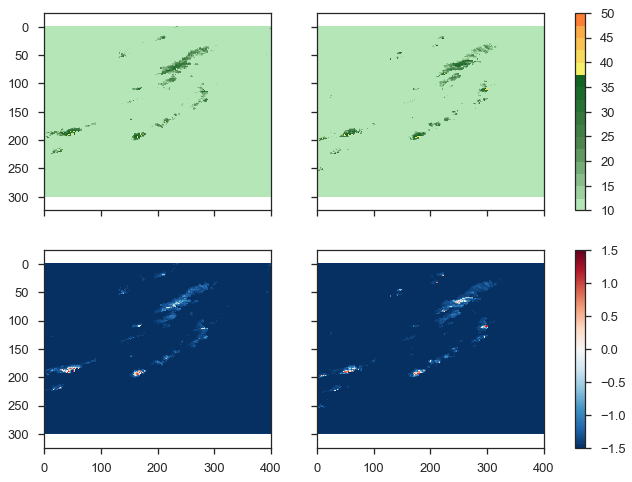

In [452]:
from ccpy.plot import get_figsize
from ccpy.plot import make_precip_colormap

figsize = get_figsize(2, 2, size=4, aspect=1.4)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,
                        figsize=figsize)
axs = axs.ravel()
axp, axc = axs[:2]
axpg, axcg = axs[2:]

cmap_kws = make_precip_colormap(clip=True)
del cmap_kws['extend']

cf = axp.imshow(_prev, **cmap_kws)
axc.imshow(_curr, **cmap_kws)
plt.colorbar(cf, ax=[axp, axc])

vmin, vmax = -1.5, 1.5
cmap = 'RdBu_r'

cf = axpg.imshow(_prev_G, vmin=vmin, vmax=vmax, cmap=cmap)
axcg.imshow(_curr_G, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(cf, ax=[axpg, axcg])

Gaussian convolution

9
1.2490457724 -1.49546743597
-0.517919058764 -1.49546743597


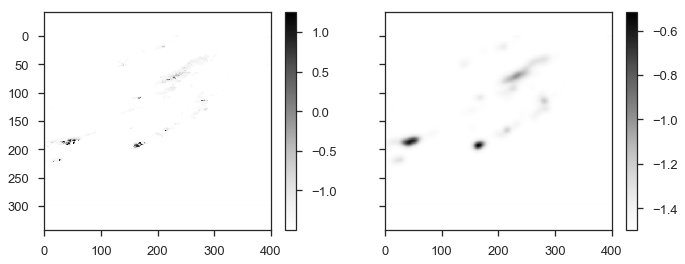

In [453]:
from scipy.ndimage.filters import gaussian_filter, gaussian_filter1d

print(σ)
_prev_G_smooth = gaussian_filter(_prev_G, σ/scale)

figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

ucf = axu.imshow(_prev_G)
vcf = axv.imshow(_prev_G_smooth)
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(_prev_G.max(), _prev_G.min())
print(_prev_G_smooth.max(), _prev_G_smooth.min())

Approximating spatial derivatives (4th order) with convolutional masks

1.2490457724 -1.49546743597
0.113924553986 -0.111365297367


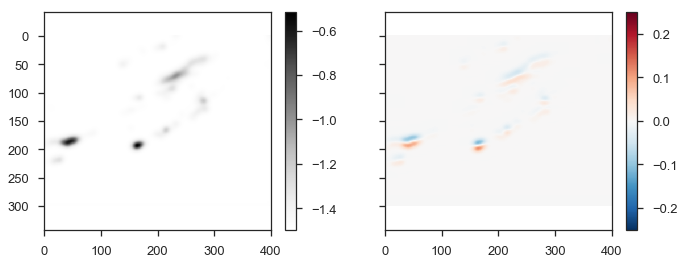

In [454]:
from scipy.ndimage.filters import convolve, convolve1d

#
_x = convolve1d(_prev_G_smooth, mask_x, axis=0)
    
figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

ucf = axu.imshow(_prev_G_smooth)
vcf = axv.imshow(_x, vmin=-.25, vmax=.25, cmap='RdBu_r')
plt.colorbar(ucf, ax=axu)
plt.colorbar(vcf, ax=axv)

print(_prev_G.max(), _prev_G.min())
print(_x.max(), _x.min())

### Towards a solution

It seems like it'll be hard, at least initially, to try to adapt this methodology to standard MG libraries. I think the best first step is just to try to directly re-produce the main methodology leaning on NumPy, and possible SciP+scikit-image for some specific processing tools.

The main method, `CalcFlow`, will be implemented as a discrete 

### Wrapping `VarFlow`

In [455]:
def uni_to_uni(x, ai, bi, af=-1., bf=1., clip=True):    
    """ Transform a uniform random variable to one with another set
    of lower/upper bounds.
    Parameters
    ----------
    x : float
        coordinate in original uniform variable space
    ai, bi : float
        lower and upper bounds of the original uniform distribution
    af, bf : float
        lower and upper bounds of the destination uniform distribution
    Returns
    -------
    float, random variable in new uniform distribution
    """
    x = x.copy()
    if clip:
        x = np.clip(x, ai, bi)    
    return ((bf-af)/(bi-ai))*(x - ai) + af

imgA = _prev.copy().astype('int32')
imgB = _curr.copy().astype('int32')

print(imgA.min(), imgA.max())
imgA = uni_to_uni(imgA, 0., 100., 0, 255.).astype('int32')
imgB = uni_to_uni(imgB, 0., 100., 0, 255.).astype('int32')
print(imgA.min(), imgA.max())

-20 45
0 114


In [459]:
from ROVER import do_rover, do_rover_original

# We have to transpose the image to reflect OpenCV's preference for width/height
# order
imgAT = np.ascontiguousarray(imgA.T)
imgBT = np.ascontiguousarray(imgB.T)
width, height = imgAT.shape
u, v = do_rover_original(
    imgAT, imgBT,
    start_level=2, max_level=6, n1=2, n2=4,
    rho=ρ, alpha=α, sigma=σ
)
## Weird post-processing
# Swap back to Python row/column order
u, v = u.T, v.T
# The u and v arrays are swapped
_temp = u.copy()
u = v.copy()
v = _temp.copy()
# They're also reversed column-wise
u, v = u[..., ::-1], v[..., ::-1]
# And they're negative?
u, v = -u, -v
# And scale by the grid parameters
u *= Δx/Δt
v *= Δy/Δt

print(u.min(), u.max())

print(imgA.shape)
print(imgAT.shape)
print(u.shape)

0
0.0189980759285 0.505115447938
(301, 401)
(401, 301)
(301, 401)


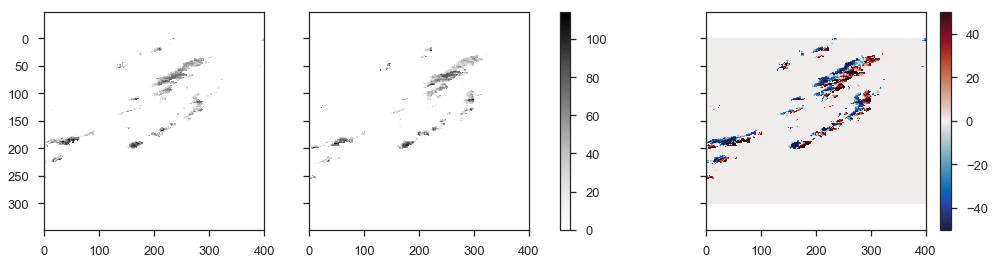

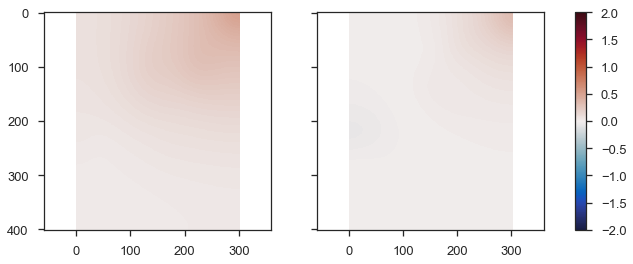

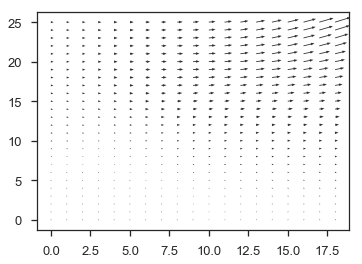

In [460]:
from cmocean import cm

figsize = get_figsize(1, 3, size=4, aspect=1.4)
fig, (axu, axv, axd) = plt.subplots(1, 3, sharex=True, sharey=True,
                               figsize=figsize)
ucf = axu.imshow(imgA)
vcf = axv.imshow(imgB)
plt.colorbar(ucf, ax=[axu, axv])
cf = axd.imshow(imgB - imgA, vmin=-50, vmax=50, cmap=cm.balance)
plt.colorbar(cf, ax=axd)


figsize = get_figsize(1, 2, size=4, aspect=1.4)
fig, (axu, axv) = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=figsize)

uu = 2
cmap_kws = dict(vmin=-uu, vmax=uu, cmap=cm.balance)

ucf = axu.imshow(u[...,::-1].T, **cmap_kws)
vcf = axv.imshow(v[...,::-1].T, **cmap_kws)
plt.colorbar(ucf, ax=[axu, axv])

##

figsize = get_figsize(1, 1, size=4, aspect=1.4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

s = np.sqrt(u**2 + v**2)
mask = s < 0
um = u.copy()
um[mask] = np.nan
vm = v.copy()
vm[mask] = np.nan

rs = 16
# We do the transpose here to match imshow order
ax.quiver(um[::rs, ::rs].T, vm[::rs, ::rs].T,
          headlength=4, headwidth=3, angles='xy',
          scale_units='xy', scale=0.5, alpha=0.8,
          color='k')

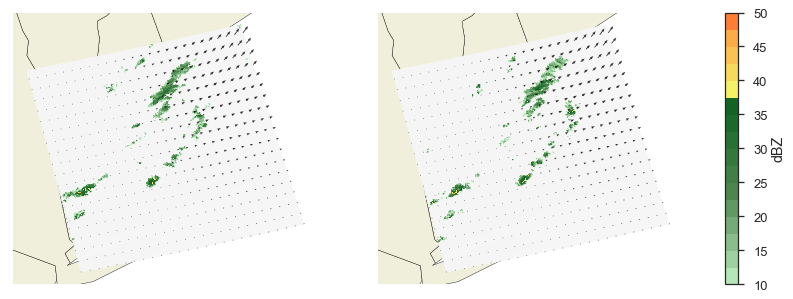

In [461]:
from ccpy.plot import usa_states_ax, make_precip_colormap
import cartopy.crs as ccrs

cmap_kws = make_precip_colormap(clip=False)
del cmap_kws['extend']

# Re-center staggered dimensions by taking averages between edges
_ut = u.copy()
_vt = v.copy()

figsize = get_figsize(1, 2, size=5, aspect=1.5)
fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True,
                        subplot_kw=dict(
                            projection=STATE_PROJ, aspect='auto'
                        ))
axl, axr = axs[:]
for ax in axs:
    ax = usa_states_ax(ax=ax)
    
pc = axl.pcolormesh(x, y, _prev, 
                    transform=ccrs.PlateCarree(), zorder=100, 
                    rasterized=True, linewidth=0, edgecolor='face', **cmap_kws)
pc = axr.pcolormesh(x, y, _curr, 
                    transform=ccrs.PlateCarree(), zorder=100, 
                    rasterized=True, linewidth=0, edgecolor='face', **cmap_kws)
for ax in axs:
    ax.quiver(x[::rs], y[::-rs],
              _ut[::rs, ::rs], _vt[::rs, ::rs],
              headlength=4, headwidth=3, angles='xy', 
              scale_units='inches', scale=5, alpha=0.8,
              color='k', zorder=200, transform=ccrs.PlateCarree())
    ax.autoscale()
    
plt.colorbar(pc, ax=axs, label='dBZ')